#                                     Heart Stroke Data Analysis and ML Prediction

## Problem Statement
### Significance
- Stroke is one of the leading causes of death worldwide. Early identification of it is crucial for treating it and for implementing preventative measures and ensuring prompt medical intervention.
- The task involves predicting whether a person is likely to get a stroke, using features such as Age, Gender, Heart Disease, Smoking Status etc.

-----

### Dataset Description
- We have a total of 5110 rows, and only 249 of them have stroke, we will see how this becomes an issue while training the model.

-----

### Attribute Information
1) **id** : unique identifier
2) **gender** : "Male", "Female" or "Other"
3) **age** : age of the patient
4) **hypertension** : 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) **heart_disease** : 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) **ever_married** : "No" or "Yes"
7) **work_type** : "children", "Govt_job", "Never_worked", "Private" or "Self-employed"
8) **residence_type** : "Rural" or "Urban"
9) **avg_glucose_level** : average glucose level in blood
10) **bmi** : body mass index
11) **smoking_status** : "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) **stroke** : 1 if the patient had a stroke or 0 if not

-----

### Dataset Source
- Kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset.

### Importing neccessary libraries

In [367]:
import pandas as pd
import numpy as np
import sqlite3
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  
warnings.filterwarnings('ignore')

### Importing data using plain python
- As we are using a csv file, we are splitting each row on commas(,)
- We are creating two tables, one for physical details such as gender, age, heart_disease etc., and the other for each specific person details such as their glucose levels, BMI etc.,
- As there might be duplicates in the combination of physical details, we are using a dictionary to store that information
- We are also formatting the data according to the kind of data present in that column

In [368]:

# gender 1, age 2, hyper 3, heart_disease 4, ever_married 5, work_type 6, residence_type 7, smoking_status 10, stroke 11

with open('/Users/soumyavoorugonda/Downloads/Stroke_data.csv', 'r') as file:
    physical_data = {}
    person_data = []
    dc = dict()
    cnt = 0
    for row in file:
        row = row.strip().split(',')
        if 'id' in row:
            continue
        else:
            physical = row[1]+row[2]+row[3]+row[4]+row[5]+row[6]+row[7]+row[10]+row[11]
            
            if physical not in dc:
                dc[physical]=cnt
                cnt+=1
                
            row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9], row[10], row[11]= int(row[0]), row[1], int(float(row[2])), int(row[3]), int(row[4]), row[5], row[6], row[7], float(row[8]), float(row[9]), row[10], int(row[11])  
            physical_data[physical] = (dc[physical],row[1],row[2], row[3], row[4], row[5], row[6], row[7], row[10], row[11])
            person_data.append((dc[physical] ,row[8], row[9]))


In [369]:
tmp = []
for k in physical_data:
    tmp.append(physical_data[k])
physical_data = tmp
physical_data[0]

(0, 'Male', 67, 0, 1, 'Yes', 'Private', 'Urban', 'formerly smoked', 1)

# Methodology 
### Normalization:
- Transforming raw data into normalized tables, Physical and HealthMetrics.

### Loading into Pandas:
- Combine the above tables to get the original data
- Load this data into Pandas DataFrames for analysis.

### Exploratory Data Analysis (EDA):
- Statistically summarize data and create visualizations to understand patterns and relationships.

### Machine Learning (ML) Modeling:
- Preparing data, selecting ML models (e.g., RandomForest), and train them to predict stroke risk.

### Model Evaluation:
- Assess model performance using metrics like accuracy and confusion matrix.


# Normalization

### Steps to Normalizing the database. (Referenced from Textbook)

- **create_connection** : returns the connection object to the database
- **create_table** : creates a table based on the input sql query
- **execute_sql_statement** : executes a given sql statement on the given connection

In [370]:

import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

### Creating Patients and HealthMetrics Tables 

**Physical Table** :
  - **physical_id** : unique identifier for each combination
  - **gender** : specifies the type of gender
  - **age** : age
  - **hypertension** : specifies whether the patient have hypertension or not
  - **heart_disease** : specifies whether the patient have heart_disease or not
  - **ever_married** : if the patient has been married or not
  - **work_type** : type of work
  - **residence_type** : residence type of the patient
  - **smoking_status** : whether the patient has any smoking habit or not
  - **stroke** : specifies whether the patient has stroke or not

    
**HealthMetrics Table** :
  - **medical_id** : unique identifier of each patient
  - **physical_id** : foreign key that maps with a combination in the physical table
  - **avg_glucose_level** : glucose level of the patient
  - **bmi** : Body Mass Index of the patient

In [371]:

conn = create_connection('Heart_stroke.db', delete_db = True)

# gender 1, age 2, hyper 3, heart_disease 4, ever_married 5, work_type 6, residence_type 7, smoking_status 10, stroke 11

create_physical_sql = ''' CREATE TABLE IF NOT EXISTS Physical(
    physical_id INTEGER NOT NULL PRIMARY KEY,
    gender TEXT NOT NULL,
    age INTEGER NOT NULL,
    hypertension INTEGER NOT NULL,
    heart_disease INTEGER NOT NULL,
    ever_married TEXT NOT NULL,
    work_type TEXT NOT NULL,
    residence_type TEXT NOT NULL,
    smoking_status TEXT NOT NULL,
    stroke INTEGER NOT NULL); '''
create_table(conn, create_physical_sql)

create_healthmetric_sql = ''' CREATE TABLE IF NOT EXISTS HealthMetrics(
    medical_id INTEGER PRIMARY KEY NOT NULL,
    physical_id INTEGER NOT NULL,
    avg_glucose_level FLOAT NOT NULL,
    bmi FLOAT NOT NULL,
    FOREIGN KEY (physical_id) REFERENCES Physical(physical_id));'''
create_table(conn, create_healthmetric_sql)


### Inserting Data into the tables
- Making use of *INSERT INTO* SQL Query to insert values into the tables
- Here we are using *executemany* method from the cursor object to insert multiple rows at a time into the database

In [372]:
insert_physical_sql = '''INSERT INTO Physical(physical_id, gender, age, hypertension, heart_disease, ever_married, work_type, residence_type, smoking_status, stroke) VALUES (?,?,?,?,?,?,?,?,?,?)'''
cur = conn.cursor()
cur.executemany(insert_physical_sql, physical_data)

In [373]:
insert_metrics_sql = '''INSERT INTO HealthMetrics(physical_id, avg_glucose_level, bmi) VALUES (?, ?, ?)'''
cur.executemany(insert_metrics_sql, person_data)

### Loading Data into pandas for analysis 
- Here we are combining Physical and HealthMetrics tables to get the data for analysis
- Then converting the data into a pandas dataframe

In [374]:
sql_statement = '''
    SELECT
        Physical.physical_id,
        HealthMetrics.medical_id,
        Physical.gender,
        Physical.age,
        Physical.ever_married,
        Physical.work_type,
        Physical.residence_type,
        Physical.hypertension,
        Physical.heart_disease,
        HealthMetrics.avg_glucose_level,
        HealthMetrics.bmi,
        Physical.smoking_status,
        Physical.stroke
    FROM
        HealthMetrics
    LEFT JOIN
        Physical ON Physical.physical_id = HealthMetrics.physical_id;
'''
data = cur.execute(sql_statement).fetchall()

#Creating and loading the dataframe
columns = ['physical_id', 'medical_id', 'gender', 'age', 'ever_married', 'work_type', 'residence_type', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
df = pd.DataFrame(data, columns = columns)

conn.commit()
cur.close()


### Raw data

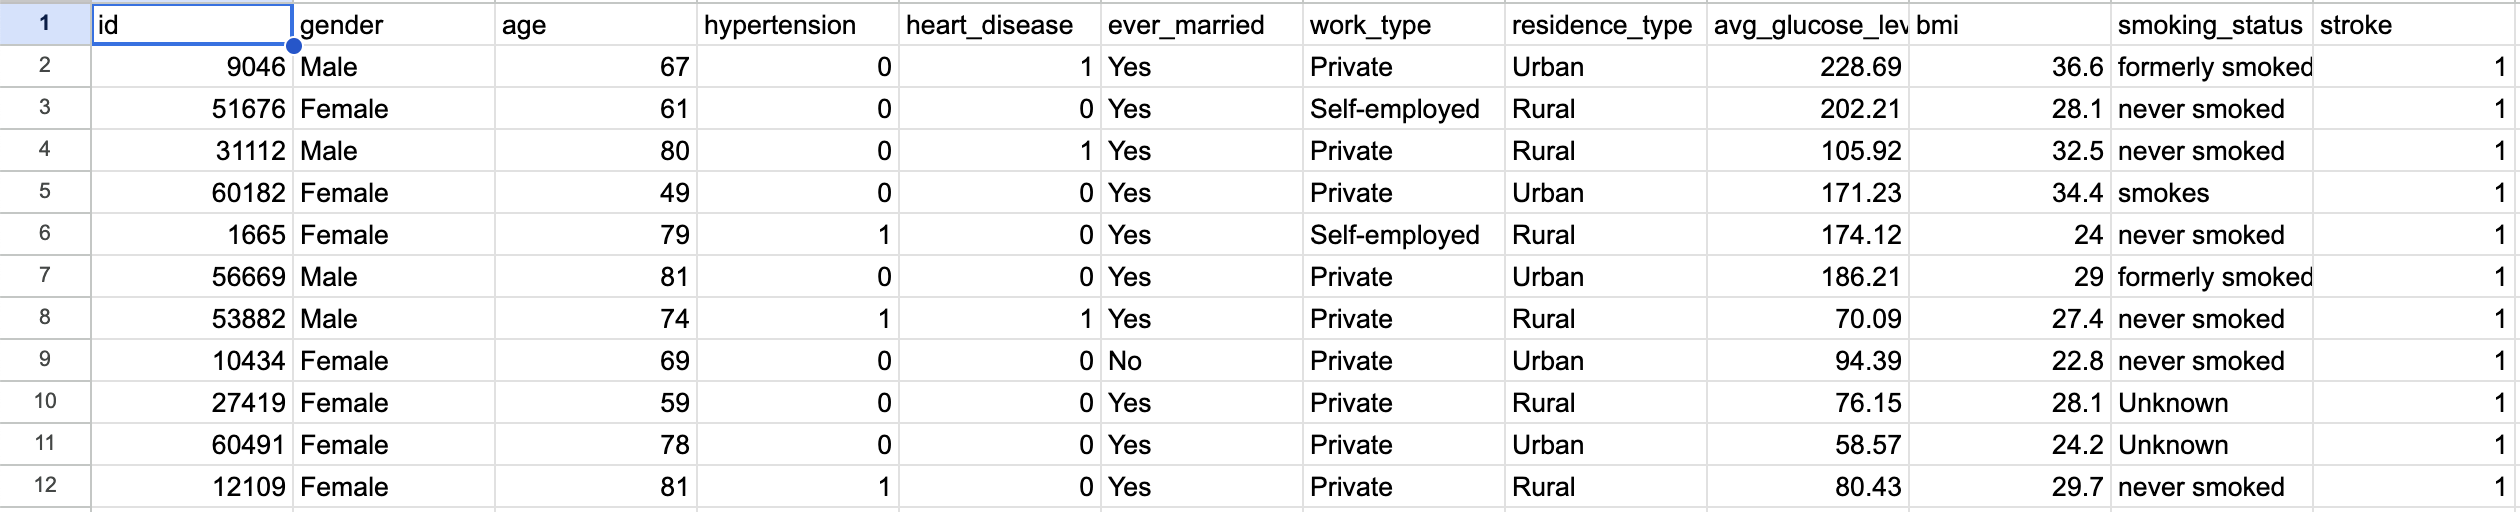

### Normalized data

In [375]:
df.head()

,physical_id,medical_id,gender,age,ever_married,work_type,residence_type,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,0,1,Male,67,Yes,Private,Urban,0,1,228.69,36.6,formerly smoked,1
1,1,2,Female,61,Yes,Self-employed,Rural,0,0,202.21,28.1,never smoked,1
2,2,3,Male,80,Yes,Private,Rural,0,1,105.92,32.5,never smoked,1
3,3,4,Female,49,Yes,Private,Urban,0,0,171.23,34.4,smokes,1
4,4,5,Female,79,Yes,Self-employed,Rural,1,0,174.12,24.0,never smoked,1


# Exploratory Data Analysis

### Checking for NULL values

In [376]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   physical_id        5110 non-null   int64  
 1   medical_id         5110 non-null   int64  
 2   gender             5110 non-null   object 
 3   age                5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   residence_type     5110 non-null   object 
 7   hypertension       5110 non-null   int64  
 8   heart_disease      5110 non-null   int64  
 9   avg_glucose_level  5110 non-null   float64
 10  bmi                5110 non-null   float64
 11  smoking_status     5110 non-null   object 
 12  stroke             5110 non-null   int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 519.1+ KB


In [377]:
df.isnull().sum()

physical_id          0
medical_id           0
gender               0
age                  0
ever_married         0
work_type            0
residence_type       0
hypertension         0
heart_disease        0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Impact of smoking on predicting stroke
- From the bar plot we can see that when a patient falls in the *formerly smoked* or *smokes* category there is a bit higher chance for having a stroke than the patients who never smoke

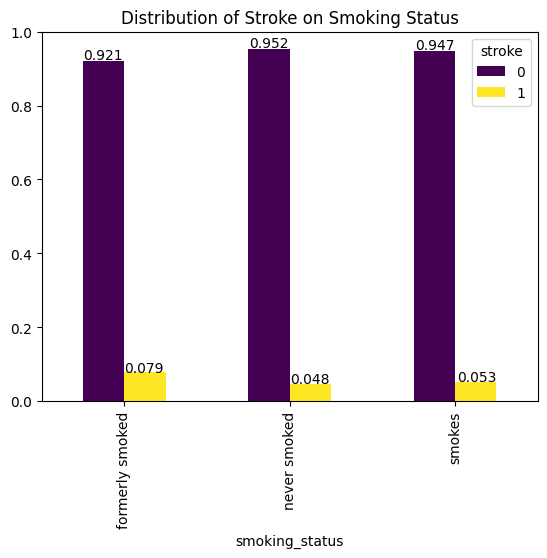

In [378]:
# Count occurrences of combinations
tmp_df = df.loc[df['smoking_status']!='Unknown']
count_df = tmp_df.groupby(['smoking_status', 'stroke']).size().unstack()
count_df = count_df.div(count_df.sum(axis=1), axis=0)  # Normalize to get proportions

ax = count_df.plot(kind='bar', stacked=False, colormap='viridis')

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.set_title('Distribution of Stroke on Smoking Status')
plt.show()

### Impact of Heart Disease on stroke prediction
- Following bar plot shows that patients that have a heart disease are at a higher risk of getting a stroke

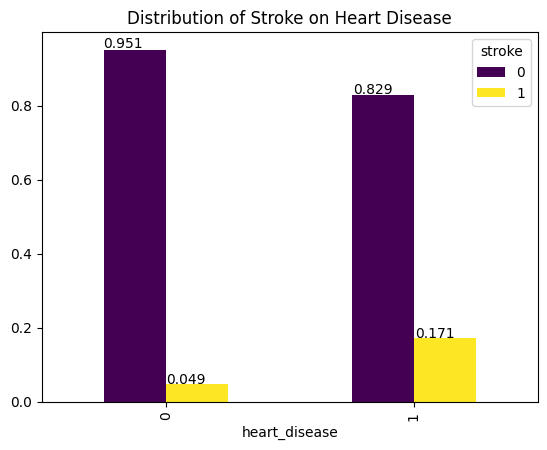

In [379]:
# Count occurrences of combinations
count_df = tmp_df.groupby(['heart_disease', 'stroke']).size().unstack()
count_df = count_df.div(count_df.sum(axis=1), axis=0)  # Normalize to get proportions

ax = count_df.plot(kind='bar', stacked=False, colormap='viridis')

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.set_title('Distribution of Stroke on Heart Disease')
plt.show()


### Stroke Risk across different ages
- Following distribution plot shows that there is high distribution of patients that have stroke when the age increases
- This shows that as the Age increases the chances of getting stroke increases too

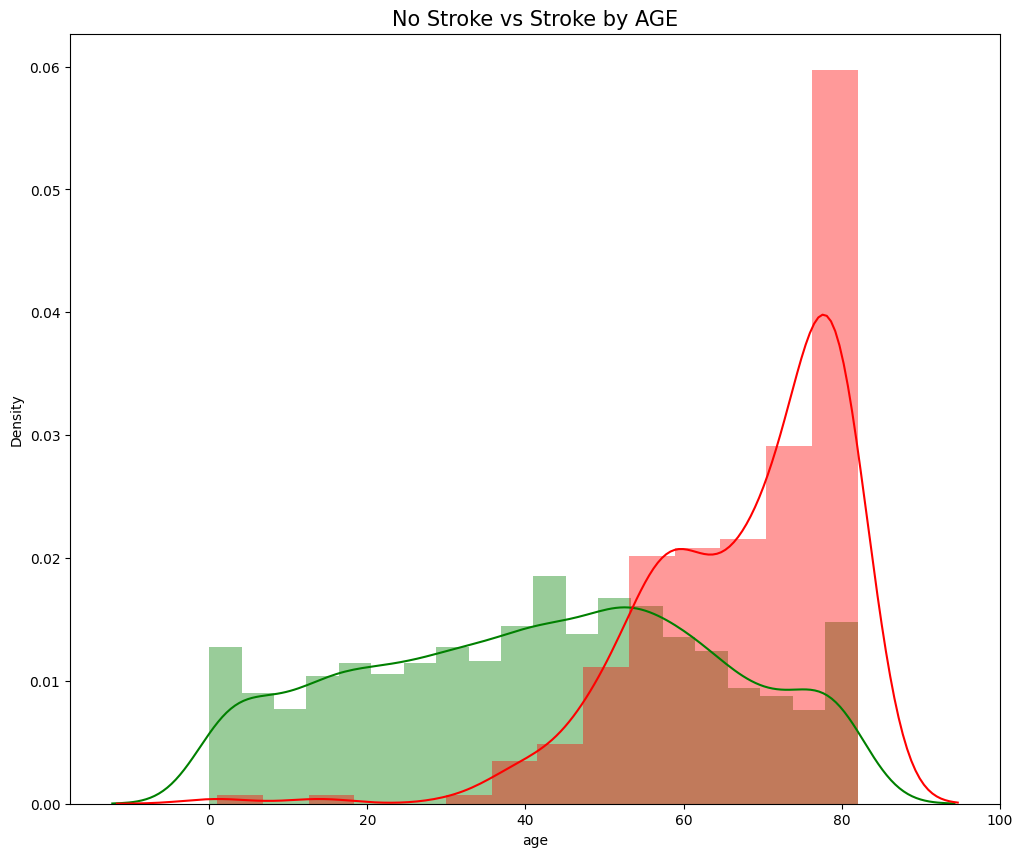

In [380]:
plt.figure(figsize=(12,10))

sns.distplot(df[df['stroke'] == 0]["age"], color='green') # No Stroke - green
sns.distplot(df[df['stroke'] == 1]["age"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by AGE', fontsize=15)
plt.show()


### Converting non-numeric columns to numeric in Pandas
- In the given data columns like *gender*, *smoking_stats*, *ever_married*, *work_type* and *residence_type* have text type of categorical variables
- So before sending our data to a Machine Learning model first we have to encode these features
- We can easily do that using *get_dummies* method from pandas

In [381]:
print("Before converting text categorical variables: ")
print(df.head())
print('\n')
non_numeric_columns = ['gender', 'smoking_status', 'ever_married', 'work_type', 'residence_type' ]
df = pd.get_dummies(df, columns=non_numeric_columns)
print("After ")
print(df.head())


Before converting text categorical variables: 
   physical_id  medical_id  gender  age ever_married      work_type  \
0            0           1    Male   67          Yes        Private   
1            1           2  Female   61          Yes  Self-employed   
2            2           3    Male   80          Yes        Private   
3            3           4  Female   49          Yes        Private   
4            4           5  Female   79          Yes  Self-employed   

  residence_type  hypertension  heart_disease  avg_glucose_level   bmi  \
0          Urban             0              1             228.69  36.6   
1          Rural             0              0             202.21  28.1   
2          Rural             0              1             105.92  32.5   
3          Urban             0              0             171.23  34.4   
4          Rural             1              0             174.12  24.0   

    smoking_status  stroke  
0  formerly smoked       1  
1     never smoked     

# ML Algorithms

### Training and testing data
- Here we are splitting the data into training and test sets
- For training data we are taking 80% of the total data and the remaining data is used as test data

In [382]:
#Splitting data into train and test sets
x = df.drop(['stroke','physical_id', 'medical_id'], axis = 1)
y = df['stroke']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)

## RandomForest Model

RandomForest Accuracy: 0.9373776908023483


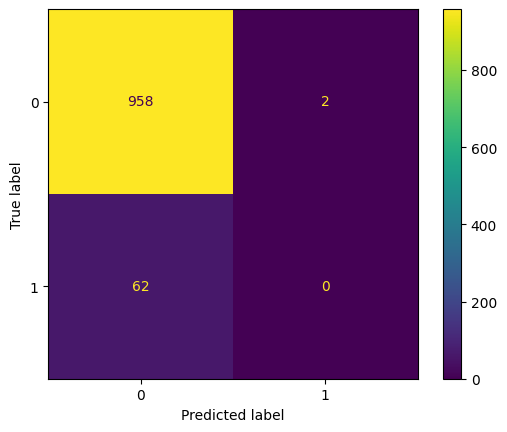

Confusion matrix: [[958   2]
 [ 62   0]]
Classification Report: 
Precision: 0.4696078431372549 Recall: 0.49895833333333334 F1-Score: 0.4838383838383839


In [383]:
#RandomForest Classifier

# fitting the model
rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 13)
rf_fit = rf_classifier.fit(x_train, y_train)

# get the predictions for test data
rf_pred = rf_fit.predict(x_test)

# get the metrics
rf_accuracy = accuracy_score(y_test, rf_pred)
conf_mat_rf = confusion_matrix(y_test, rf_pred)
class_rep_rf = classification_report(y_test, rf_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, rf_pred, average='macro')

print(f'RandomForest Accuracy: {rf_accuracy}')

# confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_rf, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()
print(f'Confusion matrix: {conf_mat_rf}')
print(f'Classification Report: ')
print(f"Precision: {precision} Recall: {recall} F1-Score: {f1_score}")

### Model Analysis :
- Even though we got good accuracy of 93%, from the confusion matrix, we can see that our model is not able to predict label = 1.
- And the same can be seen from the very low values of metrics such as Precision, Recall, F1-Score

## Decision Tree Model

Decision tree Accuracy: 0.9129158512720157


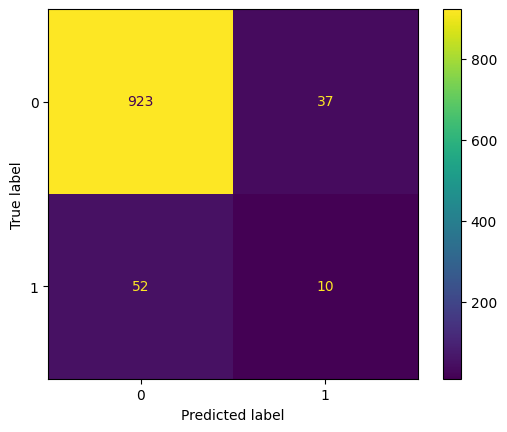

Confusion matrix: [[923  37]
 [ 52  10]]
Classification Report: 
Precision: 0.4696078431372549 Recall: 0.49895833333333334 F1-Score: 0.4838383838383839


In [384]:
# Decision tree classifier

# Fitting the model
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_fit = dt_classifier.fit(x_train, y_train)

# Predicting the test data
dt_pred = dt_fit.predict(x_test)

# Get the metrics
dt_accuracy = accuracy_score(y_test, dt_pred)
conf_mat_dt = confusion_matrix(y_test, dt_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, rf_pred, average='macro')

print(f'Decision tree Accuracy: {dt_accuracy}')

# Plots
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_dt, display_labels=dt_classifier.classes_)
disp.plot()
plt.show()
print(f'Confusion matrix: {conf_mat_dt}')
print(f'Classification Report: ')
print(f"Precision: {precision} Recall: {recall} F1-Score: {f1_score}")

#### Model Analysis :
- We are getting an accuracy of 91 from decision tree, we can see that it's less than the one that we got from the Random Forest Classifier.
- But when we compare the confusion matrices of Random Forest Model and Decision Tree model, we can see that decision tree is able to predict label=1 a bit better than the random forest model.

### Conclusion :

- From the visualizations we can see that smoking, age and having heart disease have an impact on getting a stroke
- And both Random Forest and Decision Tree Models are not able to correctly predict the patients that have a stroke, and the main reason behind this, might be the class imbalance in our dataset, as we have only 249 data points that have stroke in a total of 5110 rows